In [1]:
!pip install python-Levenshtein

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 48.8 MB/s eta 0:00:00


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
 dataX, dataY = [], []
 for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
 return np.array(dataX), np.array(dataY)

# fix random seed for reproducibility
tf.random.set_seed(7)

USD/IDR Exchange Rate from Jan 2013 - May 2023

In [4]:
start_date = '2013-01-01'
# start_date_temp = '2008-07-01'

end_date = '2023-06-01'
# end_date_temp = '2009-07-01'

data_download = yf.download('USDIDR=X', start=start_date, end=end_date, progress=False)
data = data_download.drop(['Open',
                 'High',
                 'Low',
                 'Adj Close',
                 'Volume'],axis=1)
data

,Close
Date,
2013-01-01,9609.000000
2013-01-02,9609.000000
2013-01-03,9622.500000
2013-01-04,9626.299805
2013-01-07,9770.000000
...,...
2023-05-25,14945.900391
2023-05-26,14970.000000
2023-05-29,14948.000000


Temporal Analysis

In [5]:
# extracting only the close values
values = pd.DataFrame(data['Close'])

# using shift function to shift the values.
dataframe = pd.concat([values.shift(i) for i in range(7, -2, -1)], axis=1)

# rename columns
dataframe.columns = [f't-{i}'for i in range(7, -2, -1)]
dataframe.columns = [i.replace('--', '+') for i in dataframe.columns]
dataframe.columns = [i.replace('t-0', 'Actual Close') for i in dataframe.columns]

# using shift function to shift the values.
dataframe = pd.concat([values.shift(i) for i in range(2, -2, -1)], axis=1)

# rename columns
dataframe.columns = ['t-2', 't-1', 'Actual Close', 't+1']

# remove NaN
dataframe = dataframe[2:]
dataframe = dataframe[:2710]

dataframe

,t-2,t-1,Actual Close,t+1
Date,,,,
2013-01-03,9609.000000,9609.000000,9622.500000,9626.299805
2013-01-04,9609.000000,9622.500000,9626.299805,9770.000000
2013-01-07,9622.500000,9626.299805,9770.000000,9639.099609
2013-01-08,9626.299805,9770.000000,9639.099609,9641.200195
2013-01-09,9770.000000,9639.099609,9641.200195,9632.099609
...,...,...,...,...
2023-05-24,14918.000000,14886.000000,14895.000000,14945.900391
2023-05-25,14886.000000,14895.000000,14945.900391,14970.000000
2023-05-26,14895.000000,14945.900391,14970.000000,14948.000000


In [7]:
#Get econmic indicators differential
economic_indicators_differential = pd.read_excel('/content/econ_final/Economic Indicators Differentials.xlsx', index_col=0,)

economic_indicators_differential

,Current Account Differential,Inflation Rate Differential,Interest Rate Differential,Trade Balance Differential,Foreign Exchange Reserve (USD)
Date,,,,,
2013-01-01,98899993993,0.05625,0.0410,44150000000,98100000000
2013-01-02,98899993993,0.05625,0.0410,44150000000,98100000000
2013-01-03,98899993993,0.05625,0.0410,44150000000,98100000000
2013-01-04,98899989874,0.05625,0.0410,44150000000,98100000000
2013-01-07,98899991360,0.05625,0.0410,44150000000,98100000000
...,...,...,...,...,...
2023-05-25,219300004181,0.00625,0.0051,67110000000,145200000000
2023-05-26,219300004181,0.00625,0.0051,67110000000,145200000000
2023-05-29,219300004181,0.00625,0.0051,67110000000,145200000000


<Axes: >

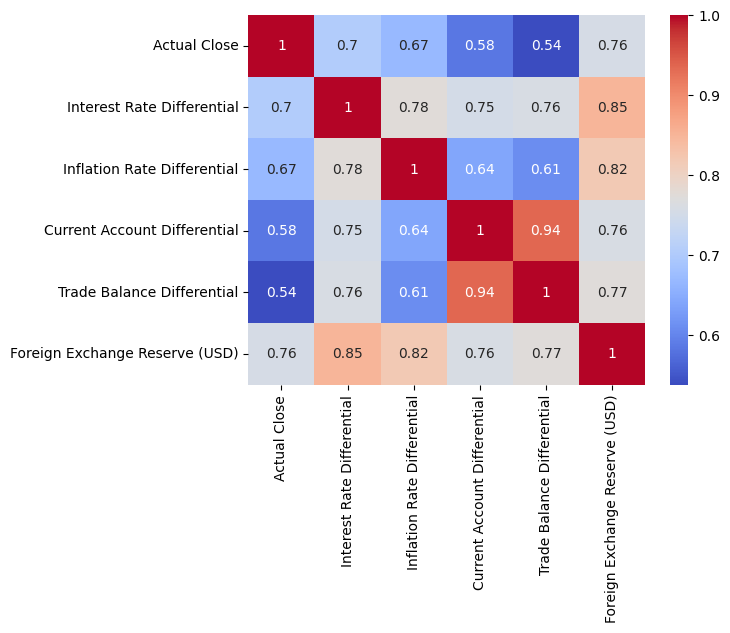

In [8]:
df = pd.DataFrame({
    'Actual Close': dataframe['Actual Close'],
    'Interest Rate Differential':economic_indicators_differential['Interest Rate Differential'],
    'Inflation Rate Differential':economic_indicators_differential['Inflation Rate Differential'],
    'Current Account Differential':economic_indicators_differential['Current Account Differential'],
    'Trade Balance Differential':economic_indicators_differential['Trade Balance Differential'],
    'Foreign Exchange Reserve (USD)':economic_indicators_differential['Foreign Exchange Reserve (USD)']
})

sns.heatmap(df.corr().abs(), annot=True, cmap='coolwarm')

In [9]:
#merge the dataframe with economic indicators with concat
time_series = pd.merge(left=dataframe, right=economic_indicators_differential, left_on=dataframe.index, right_on=economic_indicators_differential.index, how='left')
time_series.columns = [i.replace('key_0', 'Date') for i in time_series.columns]
time_series = time_series.set_index('Date')

time_series

,t-2,t-1,Actual Close,t+1,Current Account Differential,Inflation Rate Differential,Interest Rate Differential,Trade Balance Differential,Foreign Exchange Reserve (USD)
Date,,,,,,,,,
2013-01-03,9609.000000,9609.000000,9622.500000,9626.299805,98899993993,0.05625,0.0410,44150000000,98100000000
2013-01-04,9609.000000,9622.500000,9626.299805,9770.000000,98899989874,0.05625,0.0410,44150000000,98100000000
2013-01-07,9622.500000,9626.299805,9770.000000,9639.099609,98899991360,0.05625,0.0410,44150000000,98100000000
2013-01-08,9626.299805,9770.000000,9639.099609,9641.200195,98899991360,0.05625,0.0681,44150000000,98100000000
2013-01-09,9770.000000,9639.099609,9641.200195,9632.099609,98899991360,0.05625,0.0681,44150000000,98100000000
...,...,...,...,...,...,...,...,...,...
2023-05-24,14918.000000,14886.000000,14895.000000,14945.900391,219300004181,0.00625,0.0051,67110000000,145200000000
2023-05-25,14886.000000,14895.000000,14945.900391,14970.000000,219300004181,0.00625,0.0051,67110000000,145200000000
2023-05-26,14895.000000,14945.900391,14970.000000,14948.000000,219300004181,0.00625,0.0051,67110000000,145200000000


In [10]:
time_series_output = time_series.drop(['t-2',
                                       't-1',
                                       'Actual Close',
                                       'Current Account Differential',
                                       'Interest Rate Differential',
                                       'Inflation Rate Differential',
                                       'Trade Balance Differential',
                                       'Foreign Exchange Reserve (USD)'],axis=1)

time_series_output

,t+1
Date,
2013-01-03,9626.299805
2013-01-04,9770.000000
2013-01-07,9639.099609
2013-01-08,9641.200195
2013-01-09,9632.099609
...,...
2023-05-24,14945.900391
2023-05-25,14970.000000
2023-05-26,14948.000000


In [11]:
time_series_actual = time_series.drop(['t-2',
                                       't-1',
                                       't+1',
                                       'Current Account Differential',
                                       'Interest Rate Differential',
                                       'Inflation Rate Differential',
                                       'Trade Balance Differential',
                                       'Foreign Exchange Reserve (USD)'],axis=1)

time_series_actual

,Actual Close
Date,
2013-01-03,9622.500000
2013-01-04,9626.299805
2013-01-07,9770.000000
2013-01-08,9639.099609
2013-01-09,9641.200195
...,...
2023-05-24,14895.000000
2023-05-25,14945.900391
2023-05-26,14970.000000


In [12]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
time_series = scaler.fit_transform(time_series)

time_series

array([[0.0028342 , 0.0028342 , 0.00478636, ..., 0.75597015, 0.08833463,
        0.099631  ],
       [0.0028342 , 0.00478636, 0.00533583, ..., 0.75597015, 0.08833463,
        0.099631  ],
       [0.00478636, 0.00533583, 0.02611557, ..., 0.75597015, 0.08833463,
        0.099631  ],
       ...,
       [0.7672151 , 0.77457554, 0.77806046, ..., 0.4880597 , 0.38659392,
        0.96863469],
       [0.77457554, 0.77806046, 0.77487915, ..., 0.4880597 , 0.38659392,
        0.96863469],
       [0.77806046, 0.77487915, 0.77661441, ..., 0.4880597 , 0.38659392,
        0.96863469]])

In [13]:
# normalize the dataset
scaler_output = MinMaxScaler(feature_range=(0, 1))
time_series_output = scaler_output.fit_transform(time_series_output)

time_series_output

array([[0.00533583],
       [0.02611557],
       [0.00718674],
       ...,
       [0.77487915],
       [0.77661441],
       [0.7793619 ]])

In [14]:
# normalize the dataset
scaler_actual = MinMaxScaler(feature_range=(0, 1))
time_series_actual = scaler_actual.fit_transform(time_series_actual)

time_series_actual

array([[0.00478636],
       [0.00533583],
       [0.02611557],
       ...,
       [0.77806046],
       [0.77487915],
       [0.77661441]])

Split Data into 80/20

In [15]:
# split into train and test sets
train_size = int(len(time_series) * 0.8)
test_size = len(time_series) - train_size
train, test = time_series[0:train_size,:], time_series[train_size:len(time_series),:]

# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

LSTM Model

In [16]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

Epoch 1/100
2164/2164 - 7s - loss: 0.0187 - 7s/epoch - 3ms/step
Epoch 2/100
2164/2164 - 4s - loss: 7.6772e-04 - 4s/epoch - 2ms/step
Epoch 3/100
2164/2164 - 4s - loss: 7.7832e-04 - 4s/epoch - 2ms/step
Epoch 4/100
2164/2164 - 5s - loss: 7.3248e-04 - 5s/epoch - 2ms/step
Epoch 5/100
2164/2164 - 4s - loss: 7.4867e-04 - 4s/epoch - 2ms/step
Epoch 6/100
2164/2164 - 4s - loss: 7.3206e-04 - 4s/epoch - 2ms/step
Epoch 7/100
2164/2164 - 5s - loss: 7.1502e-04 - 5s/epoch - 2ms/step
Epoch 8/100
2164/2164 - 4s - loss: 6.9884e-04 - 4s/epoch - 2ms/step
Epoch 9/100
2164/2164 - 4s - loss: 6.9621e-04 - 4s/epoch - 2ms/step
Epoch 10/100
2164/2164 - 5s - loss: 6.9210e-04 - 5s/epoch - 2ms/step
Epoch 11/100
2164/2164 - 4s - loss: 6.7916e-04 - 4s/epoch - 2ms/step
Epoch 12/100
2164/2164 - 4s - loss: 6.6130e-04 - 4s/epoch - 2ms/step
Epoch 13/100
2164/2164 - 5s - loss: 6.6890e-04 - 5s/epoch - 2ms/step
Epoch 14/100
2164/2164 - 4s - loss: 6.5785e-04 - 4s/epoch - 2ms/step
Epoch 15/100
2164/2164 - 5s - loss: 6.5987e-04 

In [17]:
# invert predictions
trainPredict = scaler_output.inverse_transform(trainPredict)
trainY = scaler_output.inverse_transform([trainY])
testPredict = scaler_output.inverse_transform(testPredict)
testY = scaler_output.inverse_transform([testY])

In [18]:
# calculate RMSE for LSTM
score = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Score: %.5f RMSE' % (score))

# calculate MSE for LSTM
score = mean_squared_error(testY[0], testPredict[:,0])
print('Score: %.5f MSE' % (score))

# calculate MAE for LSTM
score = mean_absolute_error(testY[0], testPredict[:,0])
print('Score: %.5f MAE' % (score))

# calculate R2 for LSTM
score = r2_score(testY[0], testPredict[:,0])
print('Score: %.5f R2' % (score))

Score: 81.63643 RMSE
Score: 6664.50703 MSE
Score: 66.63707 MAE
Score: 0.96743 R2


In [19]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(time_series)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(time_series)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(time_series)-1, :] = testPredict


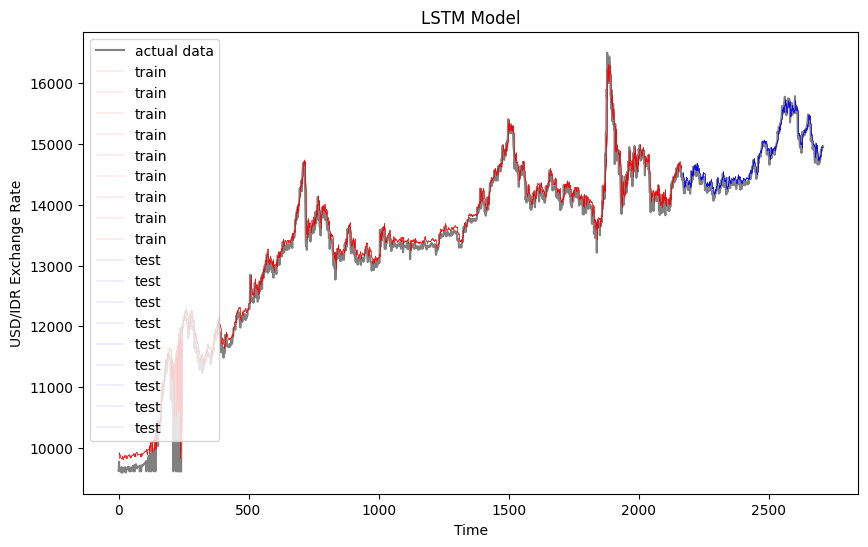

In [26]:
# plot baseline and predictions
plt.figure(figsize=(10,6))
plt.plot(scaler_actual.inverse_transform(time_series_actual),color="#a3a1a0",linewidth='1.5',label='actual data')
plt.plot(trainPredictPlot,color='red',linewidth='0.1',label='train')
plt.plot(testPredictPlot,color='blue',linewidth='0.1',label='test')
plt.title('LSTM Model')
plt.xlabel('Time')
plt.ylabel('USD/IDR Exchange Rate')
plt.legend()
plt.show()

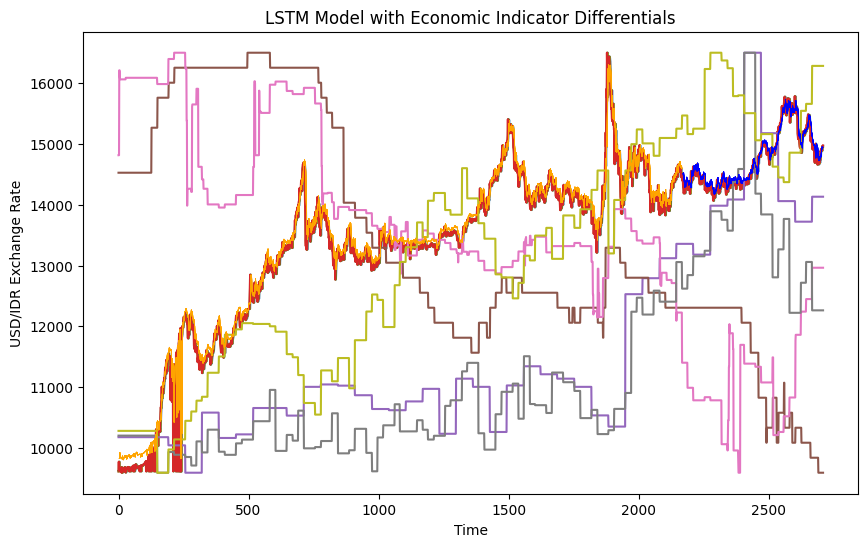

In [27]:
plt.figure(figsize=(10,6))
plt.plot(scaler_output.inverse_transform(time_series))
plt.plot(trainPredictPlot,color='orange',linewidth='0.5')
plt.plot(testPredictPlot,color='blue',linewidth='0.5')
plt.title('LSTM Model with Economic Indicator Differentials')
plt.xlabel('Time')
plt.ylabel('USD/IDR Exchange Rate')
plt.show()

In [63]:
fb = pd.read_csv('/content/fbprophet.csv', index_col=0,)
fb = fb[5:]
fb

,fbprophet Model
Date,
2021-05-10,14349.448251
2021-05-11,14248.818203
2021-05-12,14256.681703
2021-05-13,14302.131371
2021-05-14,14250.023139
...,...
2023-05-24,14720.862351
2023-05-25,14729.063820
2023-05-26,14709.089446


In [57]:
df2 = pd.DataFrame(testPredictPlot)
df2 = df2[2171:2708]
df2.columns = ['LSTM Predicted','2','3','4','5','6','7','8','9']
df2=df2.drop(['2','3','4','5','6','7','8','9'],axis=1)
df2

,LSTM Predicted
2171,14517.436523
2172,14475.475586
2173,14530.998047
2174,14471.957031
2175,14398.973633
...,...
2703,14898.514648
2704,14908.720703
2705,14951.009766
2706,14954.063477


In [64]:
# Create a DataFrame to store predicted values
predicted_data = pd.DataFrame({'Date': fb.index, 'LSTM Model': df2['LSTM Predicted']})


# Export predicted values to a CSV file
predicted_data.to_csv('LSTM.csv', index=False)